# Import of required packages

In [7]:
import tensorflow.keras
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

import pickle
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, GRU
#from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
import pickle


# set random seeds
np.random.seed(1)
tf.random.set_seed(2)


check_gpu = len(tf.config.list_physical_devices('GPU')) > 0
print('GPU is', 'available' if check_gpu else 'NOT available')


GPU is available


# Definition of functions to prepare the data 

In [8]:
# Function to extract the input data excluding the labels
def prepare_x(data):
    df1 = data[:, :40]
    return np.array(df1)

# Function to extract the labels corresponding to the input data
def get_label(data):
    lob = data[:, -len(label_lookback):]
    return lob

# Function to reshape the input data (X and y) into the right input shape asked for by the model
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

# Function to prepare the input data (X) and extract the desired label for model training
def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = np_utils.to_categorical(y, 3)
    return x, y

# Function to create a set of labels; takes the lookback, the alpha and the label type as input
def create_labels(df, label_lookback, label_alpha, label_type = 2):
    # label_type=1 corresponds to equation 4 in the thesis
    # lable_type=2 corresponds to equation 5 in the thesis
    cols = [c for c in df.columns if c[:7] != 'label_k']
    df = df[cols].copy()
    for position, k in enumerate(label_lookback):
        if label_type == 1:
            df[f"label_k_{k}"] = (df.rolling(k, closed='left').mid_price.mean().shift(-(k+1)) - df['mid_price']) / df['mid_price']
        else:
            df[f"label_k_{k}"] = (df.rolling(k, closed='left').mid_price.mean().shift(-(k+1)) - df.rolling(k+1).mid_price.mean()) / df.rolling(k+1).mid_price.mean()
            #df[f"m_minus_k_{k}"] = df.rolling(k+1).mid_price.mean()
            #df[f"m_plus_k_{k}"] = df.rolling(k, closed='left').mid_price.mean().shift(-(k+1))
        df[f"label_k_{k}"] = np.where(df[f"label_k_{k}"] >= label_alpha[position], 1, np.where(df[f"label_k_{k}"] <= -label_alpha[position], 3, 2))
        df[f"label_k_{k}"] = df[f"label_k_{k}"].astype('category')
    return df

# Function to create a confusion matrix for any given prediction/label set
def cfm_plot(labels, predictions, title):
    plt.rcParams.update({'font.size': 32})
    cfm = tf.math.confusion_matrix(np.argmax(labels, axis=1), np.argmax(predictions, axis=1)).numpy()
    classes = ["Up","Stationary","Down"]
    ax = plot_confusion_matrix(cfm, class_names=classes, figsize=(15,15))
    plt.suptitle("Confusion Matrix: "+title)
    plt.tight_layout()
    plt.savefig("./Images/CFM_"+title.replace('/','')+".jpg")
    plt.clf()
    plt.close("all")
    
# Function to create a table with accuracy, precision, recall, and F1 score for any given prediction/label set
def score_plot(labels, predictions, title, weighted = False):
    labels = np.argmax(labels, axis=1)
    predictions = np.argmax(predictions, axis=1)
    if weighted:
        average = 'weighted'
    else:
        average = 'macro'
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average = average)
    recall = recall_score(labels, predictions, average = average)
    f1 = f1_score(labels, predictions, average = average)
    data = [acc, precision, recall, f1]
    df=pd.DataFrame(data)
    df=df.T
    df.columns=["Accuracy", "Precision", "Recall", "F1"]
    print(title)
    print(df)
    df.to_csv("./Results/Scores "+title.replace('/','')+".csv")
    
# Function to create a history plot for the model training
def plot_history(path, pair, k):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,17), sharex=True)
    fig.suptitle(f'{pair} K={k}', fontsize=34)
    plt.rcParams.update({'font.size': 32})
    #plt.suptitle(code+"\nK="+str(K))
    fig.tight_layout(pad=1.2)
    fig.text(0.5, 0.02, 'Epochs', ha='center')
    with open(path, "rb") as h_file:
        history = pickle.load(h_file)
        ax[0].set_title("Accuracy")
        ax[0].plot(range(len(history["accuracy"])), history["accuracy"])
        ax[0].plot(range(len(history["accuracy"])), history["val_accuracy"])
        ax[1].set_title("Loss")
        ax[1].plot(range(len(history["loss"])), history["loss"])
        ax[1].plot(range(len(history["loss"])), history["val_loss"])
        plt.legend(("training", "validation"))
        plt.savefig(f"./Images/{pair} Training and Validation K{k}.jpg")
        plt.clf()
        plt.close("all")
        
# Function to calculate the effective possible market order price for a given trade_amount (use if groupby per timestamp)
def spread(df, trade_amount):
    cumulative_volume_ask = 0
    cumulative_volume_bid = 0
    average_ask_price = 0
    average_bid_price = 0
    
    level = 1
    while cumulative_volume_ask < trade_amount or cumulative_volume_bid < trade_amount:
        filtered = df[df['level'] == level]
        if cumulative_volume_ask < trade_amount:
            ask_amount = filtered['ask_USDT_volume'].values
            ask_price = filtered['ask_price'].values
            if cumulative_volume_ask + ask_amount < trade_amount:
                average_ask_price = (average_ask_price * cumulative_volume_ask + ask_amount * ask_price) / (cumulative_volume_ask + ask_amount)
            else:
                average_ask_price = (average_ask_price * cumulative_volume_ask + (trade_amount - cumulative_volume_ask) * ask_price) / (cumulative_volume_ask + (trade_amount - cumulative_volume_ask))
            cumulative_volume_ask += ask_amount
        if cumulative_volume_bid < 10_000:
            bid_amount = filtered['bid_USDT_volume'].values
            bid_price = filtered['bid_price'].values
            if cumulative_volume_bid + bid_amount < trade_amount:
                average_bid_price = (average_bid_price * cumulative_volume_bid + bid_amount * bid_price) / (cumulative_volume_bid + bid_amount)
            else:
                average_bid_price = (average_bid_price * cumulative_volume_bid + (trade_amount - cumulative_volume_bid) * bid_price) / (cumulative_volume_bid + (trade_amount - cumulative_volume_bid))
            cumulative_volume_bid += bid_amount
        level += 1
        if level >= 10:
            break
    return pd.DataFrame({'date': df.iloc[0,:].date, 'bid_average_price': average_bid_price, 'ask_average_price': average_ask_price})



# Model architecture

In [9]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(32, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(32, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(32, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    
    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = adam_v2.Adam(learning_rate=0.01, epsilon = 1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
 
    return model


# Model training - Individual models

In [112]:
#%%time
ks = [5, 10, 20, 50, 100]
label_lookback = ks
#label_alpha = [0.00035, 0.0005, 0.0007, 0.001, 0.0015] # BTC
#label_alpha = [0.00045, 0.00065, 0.0009, 0.0013, 0.0018] # ETH
label_alpha = [0.0005, 0.0007, 0.001, 0.0015, 0.002] # DOGE

epochs = 150
batch_size = 64
T = 100 # the length of a single input
n_hiddens = 64

pairs = ['DOGEUSDT']
class_weights = 1


for pair in pairs:
    path = f'./Data/Norm_Data/{pair}.feather'
    df = pd.read_feather(path)
    df = create_labels(df, ks, label_alpha)
    df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
    
    data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()

    # Split the data in train, validation, and test set
    split = [0.7, 0.15]

    train = data[:int(np.floor(data.shape[0] * split[0])), :]
    val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
    test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]


    for position, k in enumerate(ks):
        if class_weights:
            checkpoint_filepath = f'./Checkpoints/Latest_4M_weights_{pair}_{k}_{label_alpha[position]}'
            history_path = f'./Histories/Latest_4M_weights_{pair}_{k}_{label_alpha[position]}.pickle'
            string_add = 'weights'
        else:
            checkpoint_filepath = f'./Checkpoints/Latest_4M_{pair}_{k}_{label_alpha[position]}'
            history_path = f'.Histories/Latest_4M_{pair}_{k}_{label_alpha[position]}.pickle'
            string_add = ''

        trainX_CNN, trainY_CNN = prepare_x_y(train, position, T)
        valX_CNN, valY_CNN = prepare_x_y(val, position, T)
        testX_CNN, testY_CNN = prepare_x_y(test, position, T)
        deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
        
        if os.path.exists(checkpoint_filepath):
            deeplob.load_weights(checkpoint_filepath)
        if class_weights:
            class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(np.argmax(trainY_CNN, axis=1)),
                                            y = np.argmax(trainY_CNN, axis=1)                                                   
                                        )
            class_weights = dict(enumerate(class_weights))
        
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=25, verbose=1, min_delta=1e-4, mode="max")

        if not os.path.exists(history_path):
            print(f'Model with k={k}:')
            print(trainY_CNN.sum(axis=0))
            #print(class_weights)
            if class_weights:
                history = deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
                        epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback, early_stopping], class_weight=class_weights)
            else:
                history = deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
                        epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback, early_stopping])#, class_weight=class_weights)

            with open(os.path.join(history_path), 'wb') as h_file:
                pickle.dump(history.history, h_file)
            
            model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
            model.load_weights(checkpoint_filepath)
            predictions = model.predict(testX_CNN)
            cfm_plot(testY_CNN, predictions, f'Label_{pair}_{k}_{string_add}')
            score_plot(testY_CNN, predictions, f'Label_{pair}_{k}_{string_add}')
            
    

Model with k=5:
[71848. 70294. 74629.]
Epoch 1/150


2022-11-24 18:13:47.501013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 18:13:47.949266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 18:13:48.195276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 18:15:54.624371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 18:15:54.856455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3388/3388 - 149s - loss: 1.0953 - accuracy: 0.3579 - val_loss: 1.0978 - val_accuracy: 0.3262 - 149s/epoch - 44ms/step
Epoch 2/150
3388/3388 - 141s - loss: 1.0841 - accuracy: 0.3775 - val_loss: 1.1137 - val_accuracy: 0.3373 - 141s/epoch - 42ms/step
Epoch 3/150
3388/3388 - 143s - loss: 1.0779 - accuracy: 0.3864 - val_loss: 1.1045 - val_accuracy: 0.3513 - 143s/epoch - 42ms/step
Epoch 4/150
3388/3388 - 141s - loss: 1.0757 - accuracy: 0.3909 - val_loss: 1.1109 - val_accuracy: 0.3411 - 141s/epoch - 42ms/step
Epoch 5/150
3388/3388 - 144s - loss: 1.0741 - accuracy: 0.3959 - val_loss: 1.1105 - val_accuracy: 0.3493 - 144s/epoch - 43ms/step
Epoch 6/150
3388/3388 - 142s - loss: 1.0725 - accuracy: 0.3994 - val_loss: 1.0901 - val_accuracy: 0.3621 - 142s/epoch - 42ms/step
Epoch 7/150
3388/3388 - 141s - loss: 1.0704 - accuracy: 0.4045 - val_loss: 1.1021 - val_accuracy: 0.3577 - 141s/epoch - 42ms/step
Epoch 8/150
3388/3388 - 144s - loss: 1.0643 - accuracy: 0.4209 - val_loss: 1.0792 - val_accuracy: 0.39

Epoch 64/150
3388/3388 - 138s - loss: 0.8673 - accuracy: 0.5949 - val_loss: 0.9122 - val_accuracy: 0.5697 - 138s/epoch - 41ms/step
Epoch 65/150
3388/3388 - 141s - loss: 0.8669 - accuracy: 0.5960 - val_loss: 0.9275 - val_accuracy: 0.5604 - 141s/epoch - 42ms/step
Epoch 66/150
3388/3388 - 141s - loss: 0.8668 - accuracy: 0.5952 - val_loss: 0.9095 - val_accuracy: 0.5683 - 141s/epoch - 42ms/step
Epoch 67/150
3388/3388 - 141s - loss: 0.8655 - accuracy: 0.5966 - val_loss: 0.9312 - val_accuracy: 0.5605 - 141s/epoch - 42ms/step
Epoch 67: early stopping


2022-11-24 20:52:00.739985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 20:52:00.882450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Label_DOGEUSDT_5_weights
   Accuracy  Precision   Recall        F1
0  0.580153   0.600575  0.57149  0.578077
Model with k=10:
[71086. 71155. 74530.]
Epoch 1/150


2022-11-24 20:52:28.038603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 20:52:28.461867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 20:52:28.647517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 20:54:36.141200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 20:54:36.368178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3388/3388 - 144s - loss: 1.0981 - accuracy: 0.3440 - val_loss: 1.0983 - val_accuracy: 0.3183 - 144s/epoch - 42ms/step
Epoch 2/150
3388/3388 - 141s - loss: 1.0919 - accuracy: 0.3679 - val_loss: 1.0989 - val_accuracy: 0.3188 - 141s/epoch - 42ms/step
Epoch 3/150
3388/3388 - 141s - loss: 1.0870 - accuracy: 0.3737 - val_loss: 1.0948 - val_accuracy: 0.3383 - 141s/epoch - 42ms/step
Epoch 4/150
3388/3388 - 140s - loss: 1.0799 - accuracy: 0.3857 - val_loss: 1.1194 - val_accuracy: 0.3356 - 140s/epoch - 41ms/step
Epoch 5/150
3388/3388 - 141s - loss: 1.0761 - accuracy: 0.3955 - val_loss: 1.0974 - val_accuracy: 0.3548 - 141s/epoch - 42ms/step
Epoch 6/150
3388/3388 - 140s - loss: 1.0716 - accuracy: 0.4110 - val_loss: 1.0964 - val_accuracy: 0.3659 - 140s/epoch - 41ms/step
Epoch 7/150
3388/3388 - 141s - loss: 1.0498 - accuracy: 0.4469 - val_loss: 1.0674 - val_accuracy: 0.4104 - 141s/epoch - 42ms/step
Epoch 8/150
3388/3388 - 144s - loss: 1.0246 - accuracy: 0.4767 - val_loss: 1.0547 - val_accuracy: 0.43

Epoch 64/150
3388/3388 - 143s - loss: 0.8412 - accuracy: 0.6086 - val_loss: 0.9656 - val_accuracy: 0.5423 - 143s/epoch - 42ms/step
Epoch 65/150
3388/3388 - 144s - loss: 0.8403 - accuracy: 0.6097 - val_loss: 0.9780 - val_accuracy: 0.5285 - 144s/epoch - 43ms/step
Epoch 66/150
3388/3388 - 143s - loss: 0.8387 - accuracy: 0.6106 - val_loss: 0.9164 - val_accuracy: 0.5673 - 143s/epoch - 42ms/step
Epoch 67/150
3388/3388 - 144s - loss: 0.8383 - accuracy: 0.6115 - val_loss: 0.9178 - val_accuracy: 0.5656 - 144s/epoch - 42ms/step
Epoch 68/150
3388/3388 - 144s - loss: 0.8376 - accuracy: 0.6119 - val_loss: 0.9068 - val_accuracy: 0.5720 - 144s/epoch - 43ms/step
Epoch 69/150
3388/3388 - 146s - loss: 0.8355 - accuracy: 0.6114 - val_loss: 0.9100 - val_accuracy: 0.5698 - 146s/epoch - 43ms/step
Epoch 70/150
3388/3388 - 144s - loss: 0.8354 - accuracy: 0.6124 - val_loss: 0.9081 - val_accuracy: 0.5728 - 144s/epoch - 42ms/step
Epoch 70: early stopping


2022-11-24 23:38:37.897071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:38:38.040965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Label_DOGEUSDT_10_weights
   Accuracy  Precision    Recall        F1
0  0.573662   0.583159  0.568904  0.573832
Model with k=20:
[71103. 71505. 74163.]
Epoch 1/150


2022-11-24 23:39:05.273933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:39:05.665247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:39:05.834178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:41:15.667617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:41:15.856590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3388/3388 - 147s - loss: 1.0980 - accuracy: 0.3432 - val_loss: 1.0984 - val_accuracy: 0.3228 - 147s/epoch - 43ms/step
Epoch 2/150
3388/3388 - 146s - loss: 1.0900 - accuracy: 0.3783 - val_loss: 1.1071 - val_accuracy: 0.3330 - 146s/epoch - 43ms/step
Epoch 3/150
3388/3388 - 143s - loss: 1.0734 - accuracy: 0.4100 - val_loss: 1.1101 - val_accuracy: 0.3633 - 143s/epoch - 42ms/step
Epoch 4/150
3388/3388 - 143s - loss: 1.0349 - accuracy: 0.4637 - val_loss: 1.0728 - val_accuracy: 0.4032 - 143s/epoch - 42ms/step
Epoch 5/150
3388/3388 - 143s - loss: 0.9889 - accuracy: 0.5061 - val_loss: 1.0379 - val_accuracy: 0.4482 - 143s/epoch - 42ms/step
Epoch 6/150
3388/3388 - 143s - loss: 0.9531 - accuracy: 0.5331 - val_loss: 0.9954 - val_accuracy: 0.4921 - 143s/epoch - 42ms/step
Epoch 7/150
3388/3388 - 142s - loss: 0.9280 - accuracy: 0.5524 - val_loss: 0.9717 - val_accuracy: 0.5112 - 142s/epoch - 42ms/step
Epoch 8/150
3388/3388 - 142s - loss: 0.9147 - accuracy: 0.5628 - val_loss: 0.9638 - val_accuracy: 0.50

2022-11-25 01:24:21.771949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 01:24:21.982348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Label_DOGEUSDT_20_weights
   Accuracy  Precision    Recall        F1
0  0.555117   0.565806  0.553495  0.556255
Model with k=50:
[70182. 71872. 74717.]
Epoch 1/150


2022-11-25 01:24:55.339535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 01:24:55.760372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 01:24:55.949818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 01:27:10.226953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 01:27:10.395976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3388/3388 - 151s - loss: 1.0972 - accuracy: 0.3491 - val_loss: 1.0974 - val_accuracy: 0.3193 - 151s/epoch - 45ms/step
Epoch 2/150
3388/3388 - 145s - loss: 1.0870 - accuracy: 0.3783 - val_loss: 1.0978 - val_accuracy: 0.3333 - 145s/epoch - 43ms/step
Epoch 3/150
3388/3388 - 142s - loss: 1.0781 - accuracy: 0.3951 - val_loss: 1.0939 - val_accuracy: 0.3432 - 142s/epoch - 42ms/step
Epoch 4/150
3388/3388 - 144s - loss: 1.0663 - accuracy: 0.4217 - val_loss: 1.0981 - val_accuracy: 0.3793 - 144s/epoch - 42ms/step
Epoch 5/150
3388/3388 - 143s - loss: 1.0395 - accuracy: 0.4614 - val_loss: 1.0926 - val_accuracy: 0.3903 - 143s/epoch - 42ms/step
Epoch 6/150
3388/3388 - 144s - loss: 1.0263 - accuracy: 0.4741 - val_loss: 1.0801 - val_accuracy: 0.4003 - 144s/epoch - 42ms/step
Epoch 7/150
3388/3388 - 144s - loss: 1.0077 - accuracy: 0.4897 - val_loss: 1.0597 - val_accuracy: 0.4354 - 144s/epoch - 42ms/step
Epoch 8/150
3388/3388 - 145s - loss: 0.9930 - accuracy: 0.5037 - val_loss: 1.0989 - val_accuracy: 0.40

2022-11-25 02:41:31.470155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 02:41:31.652586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Label_DOGEUSDT_50_weights
   Accuracy  Precision    Recall        F1
0  0.403718    0.41102  0.414187  0.400212
Model with k=100:
[69610. 71461. 75700.]
Epoch 1/150


2022-11-25 02:41:59.021041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 02:41:59.500224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 02:41:59.715462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 02:44:10.794785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 02:44:10.981465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3388/3388 - 149s - loss: 1.0900 - accuracy: 0.3704 - val_loss: 1.1004 - val_accuracy: 0.3165 - 149s/epoch - 44ms/step
Epoch 2/150
3388/3388 - 146s - loss: 1.0765 - accuracy: 0.3952 - val_loss: 1.1114 - val_accuracy: 0.3455 - 146s/epoch - 43ms/step
Epoch 3/150
3388/3388 - 146s - loss: 1.0572 - accuracy: 0.4374 - val_loss: 1.0783 - val_accuracy: 0.4084 - 146s/epoch - 43ms/step
Epoch 4/150
3388/3388 - 145s - loss: 1.0315 - accuracy: 0.4651 - val_loss: 1.0881 - val_accuracy: 0.4046 - 145s/epoch - 43ms/step
Epoch 5/150
3388/3388 - 145s - loss: 1.0175 - accuracy: 0.4812 - val_loss: 1.1104 - val_accuracy: 0.3832 - 145s/epoch - 43ms/step
Epoch 6/150
3388/3388 - 145s - loss: 1.0020 - accuracy: 0.4977 - val_loss: 1.1511 - val_accuracy: 0.3627 - 145s/epoch - 43ms/step
Epoch 7/150
3388/3388 - 144s - loss: 0.9827 - accuracy: 0.5178 - val_loss: 1.1376 - val_accuracy: 0.3852 - 144s/epoch - 43ms/step
Epoch 8/150
3388/3388 - 145s - loss: 0.9559 - accuracy: 0.5431 - val_loss: 1.1790 - val_accuracy: 0.40

2022-11-25 03:49:35.016218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-25 03:49:35.184878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Label_DOGEUSDT_100_weights
   Accuracy  Precision    Recall        F1
0  0.416785   0.414474  0.394606  0.386716


## Recreation of confusion matrices

In [30]:
pair = 'BTCUSDT'
k = 100
batch_size = 64

ks = [5, 10, 20, 50, 100]
label_thresholds = {'BTCUSDT': [0.00035, 0.0005, 0.0007, 0.001, 0.0015],
                    'ETHUSDT': [0.00045, 0.00065, 0.0009, 0.0013, 0.0018],
                    'DOGEUSDT': [0.0005, 0.0007, 0.001, 0.0015, 0.002]}
label_alpha = label_thresholds[pair]
position = ks.index(k)
alpha = label_alpha[position]
label_lookback = ks
T = 100 # the length of a single input
n_hiddens = 64
checkpoint_filepath = f'./Checkpoints/Latest_4M_weights_{pair}_{k}_{alpha}'

path = f'./Data/Norm_Data/{pair}.feather'
df = pd.read_feather(path)
df = create_labels(df, ks, label_alpha)
df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()
split = [0.7, 0.15]

train = data[:int(np.floor(data.shape[0] * split[0])), :]
val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]

trainX_CNN, trainY_CNN = prepare_x_y(train, position, T)
valX_CNN, valY_CNN = prepare_x_y(val, position, T)
testX_CNN, testY_CNN = prepare_x_y(test, position, T)

class_weights = class_weight.compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(np.argmax(trainY_CNN, axis=1)),
                                            y = np.argmax(trainY_CNN, axis=1)                                                   
                                        )
class_weights = dict(enumerate(class_weights))

model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
model.load_weights(checkpoint_filepath)
#model.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
#            epochs=1, batch_size=batch_size, verbose=2, class_weight=class_weights)

predictions = model.predict(testX_CNN)
cfm_plot(testY_CNN, predictions, f'BTC/USDT k={k}')
#score_plot(testY_CNN, predictions, 'DOGEUSDT_05_weights')

2022-10-27 13:49:22.465638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-27 13:49:22.606918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Model training - Combined model

In [21]:
# Model training on combined dataset
pairs = ['BTCUSDT', 'ETHUSDT']
#ks = [5, 10, 20, 50, 100]
ks = [100]
label_lookback = ks
label_alpha = [0.0015] 
#label_alpha = [0.00035, 0.0005, 0.0007, 0.0011, 0.0015]
epochs = 150
batch_size = 64
T = 100 # the length of a single input
n_hiddens = 64

split = [0.7, 0.15]

class_weights = 1
df_agg = pd.DataFrame()

for pair in pairs:
    path = f'./Data/Norm_Data/{pair}.feather'
    df = pd.read_feather(path)
    df = create_labels(df, ks, label_alpha)
    df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
    
    data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()
    train = data[:int(np.floor(data.shape[0] * split[0])), :]
    val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
    test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]
    
    globals()[pair] = {'train': train, 'val': val, 'test': test}
    if df_agg.empty:
        df_agg = df.copy(deep=True)
        
    else:
        pd.concat([df_agg, df])   


for position, k in enumerate(ks):
    trainX_CNN, trainY_CNN = None, None
    valX_CNN, valY_CNN = None, None
    testX_CNN, testY_CNN = None, None
    if class_weights:
        checkpoint_filepath = f'./Checkpoints/Latest_4M_weights_BTC&ETH_{k}_{label_alpha[position]}'
        history_path = f'./Histories/Latest_4M_weights_BTC&ETH_{k}_{label_alpha[position]}.pickle'
        string_add = 'weights'
    else:
        checkpoint_filepath = f'./Checkpoints/Latest_4M_BTC&ETH_{k}_{label_alpha[position]}'
        history_path = f'./Histories/Latest_4M_BTC&ETH_{k}_{label_alpha[position]}.pickle'
        string_add = ''
    print(f'K: {k}')
    for pair in pairs:
        trainX, trainY = prepare_x_y(globals()[pair]["train"], position, T)
        valX, valY = prepare_x_y(globals()[pair]["val"], position, T)
        testX, testY = prepare_x_y(globals()[pair]["test"], position, T)
        
        trainX_CNN = np.concatenate((trainX_CNN, trainX)) if not trainX_CNN is None else trainX
        trainY_CNN = np.concatenate((trainY_CNN, trainY)) if not trainY_CNN is None else trainY
        valX_CNN = np.concatenate((valX_CNN, valX)) if not valX_CNN is None else valX
        valY_CNN = np.concatenate((valY_CNN, valY)) if not valY_CNN is None else valY
        testX_CNN = np.concatenate((testX_CNN, testX)) if not testX_CNN is None else testX
        testY_CNN = np.concatenate((testY_CNN, testY)) if not testY_CNN is None else testY
    '''
    print(f'trainX: {trainX_CNN.shape}')
    print(f'trainY: {trainY_CNN.shape}')
    print(f'valX: {valX_CNN.shape}')
    print(f'valY: {valY_CNN.shape}')
    print(f'testX: {testX_CNN.shape}')
    print(f'testY: {testY_CNN.shape}')
    '''
    
    if class_weights:
        class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(trainY_CNN, axis=1)),
                                        y = np.argmax(trainY_CNN, axis=1)                                                   
                                    )
        class_weights = dict(enumerate(class_weights))
    deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
    
    if os.path.exists(checkpoint_filepath):
        deeplob.load_weights(checkpoint_filepath)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=25, verbose=1, min_delta=1e-4, mode="max")

    if not os.path.exists(history_path):
        print(f'Model with k={k}:')
        print(trainY_CNN.sum(axis=0))
        #print(class_weights)
        if class_weights:
            history = deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
                    epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback, early_stopping], class_weight=class_weights)
        else:
            history = deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
                    epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback, early_stopping])#, class_weight=class_weights)

        with open(os.path.join(history_path), 'wb') as h_file:
            pickle.dump(history.history, h_file)

        model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(testX_CNN)
        cfm_plot(testY_CNN, predictions, f'BTC&ETH_{k}_{string_add}')
        score_plot(testY_CNN, predictions, f'BTC&ETH_{k}_{string_add}')
    else:
        model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(testX_CNN)
        cfm_plot(testY_CNN, predictions, f'BTC&ETH k={k}')
        score_plot(testY_CNN, predictions, f'BTC&ETH k={k}')

K: 100


2022-11-04 20:44:13.133083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-04 20:44:13.266120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


BTC&ETH k=100
   Accuracy  Precision    Recall        F1
0  0.392613   0.395609  0.389329  0.386654


# Transfer testing

In [23]:
pair = 'BTC&ETH'
test_pair = 'ETHBTC'
k = 100
batch_size = 64

ks = [5, 10, 20, 50, 100]
label_thresholds = {'BTCUSDT': [0.00035, 0.0005, 0.0007, 0.001, 0.0015],
                    'ETHUSDT': [0.00045, 0.00065, 0.0009, 0.0013, 0.0018],
                    'DOGEUSDT': [0.0005, 0.0007, 0.001, 0.0015, 0.002]}
if pair in label_thresholds:
    label_alpha = label_thresholds[pair]
else:
    label_alpha = [0.00035, 0.0005, 0.0007, 0.0011, 0.0015]
test_alphas = label_alpha
position = ks.index(k)
alpha = label_alpha[position]
test_alpha = test_alphas[position]
label_lookback = ks
T = 100 # the length of a single input
n_hiddens = 64
checkpoint_filepath = f'./Checkpoints/Latest_4M_weights_{pair}_{k}_{alpha}'

path = f'./Data/Norm_Data/{test_pair}.feather'
df = pd.read_feather(path)
df = create_labels(df, ks, test_alphas)
df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()
split = [0.7, 0.15]

train = data[:int(np.floor(data.shape[0] * split[0])), :]
val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]

trainX_CNN, trainY_CNN = prepare_x_y(train, position, T)
valX_CNN, valY_CNN = prepare_x_y(val, position, T)
testX_CNN, testY_CNN = prepare_x_y(test, position, T)

print(testY_CNN.sum(axis=0))


model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
model.load_weights(checkpoint_filepath)
#model.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
#            epochs=1, batch_size=batch_size, verbose=2, class_weight=class_weights)

predictions = model.predict(testX_CNN)
cfm_plot(testY_CNN, predictions, f'{pair} on {test_pair} k={k}')
score_plot(testY_CNN, predictions, f'{pair} on {test_pair} k={k}')

[11127. 21782. 11667.]


2022-11-05 11:13:14.471005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-05 11:13:14.628790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


BTC&ETH on ETHBTC k=100
   Accuracy  Precision    Recall       F1
0  0.386329   0.421265  0.432422  0.38781


# Creation of training history plots

In [22]:
# Plot the history graphs for model training
pairs = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT']
files = [f for f in os.listdir(os.path.join('Model', 'Histories'))]
for file in files:
    f = os.path.join(os.path.join('Model', 'Histories'), file)
    if f[-7:] == '.pickle':
        for pair in pairs:
            if pair in f:
                position = f.index(pair)
                k = f[position:].split('_')[1]
                plot_history(f, pair, k)
                
                
                

# Trading strategy simulation - Individual models

2022-11-24 15:37:54.156512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 15:37:54.341262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_pred
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

test
   Accuracy  Precision    Recall        F1
0  0.533604   0.539583  0.536015  0.537563


2022-11-24 15:38:45.162992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 15:38:45.342257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_pred
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

test
   Accuracy  Precision    Recall        F1
0  0.556721   0.562612  0.559372  0.560624


2022-11-24 15:39:33.686486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 15:39:33.883933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_pred
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

test
   Accuracy  Precision    Recall        F1
0  0.546546   0.551126  0.551398  0.551249


2022-11-24 15:40:24.832574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 15:40:25.050722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_pred
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

test
   Accuracy  Precision    Recall        F1
0  0.509946   0.524503  0.512154  0.512538


2022-11-24 15:41:15.395843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 15:41:15.564738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_pred
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/758883558.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

test
   Accuracy  Precision    Recall       F1
0  0.497462   0.501268  0.503321  0.49621


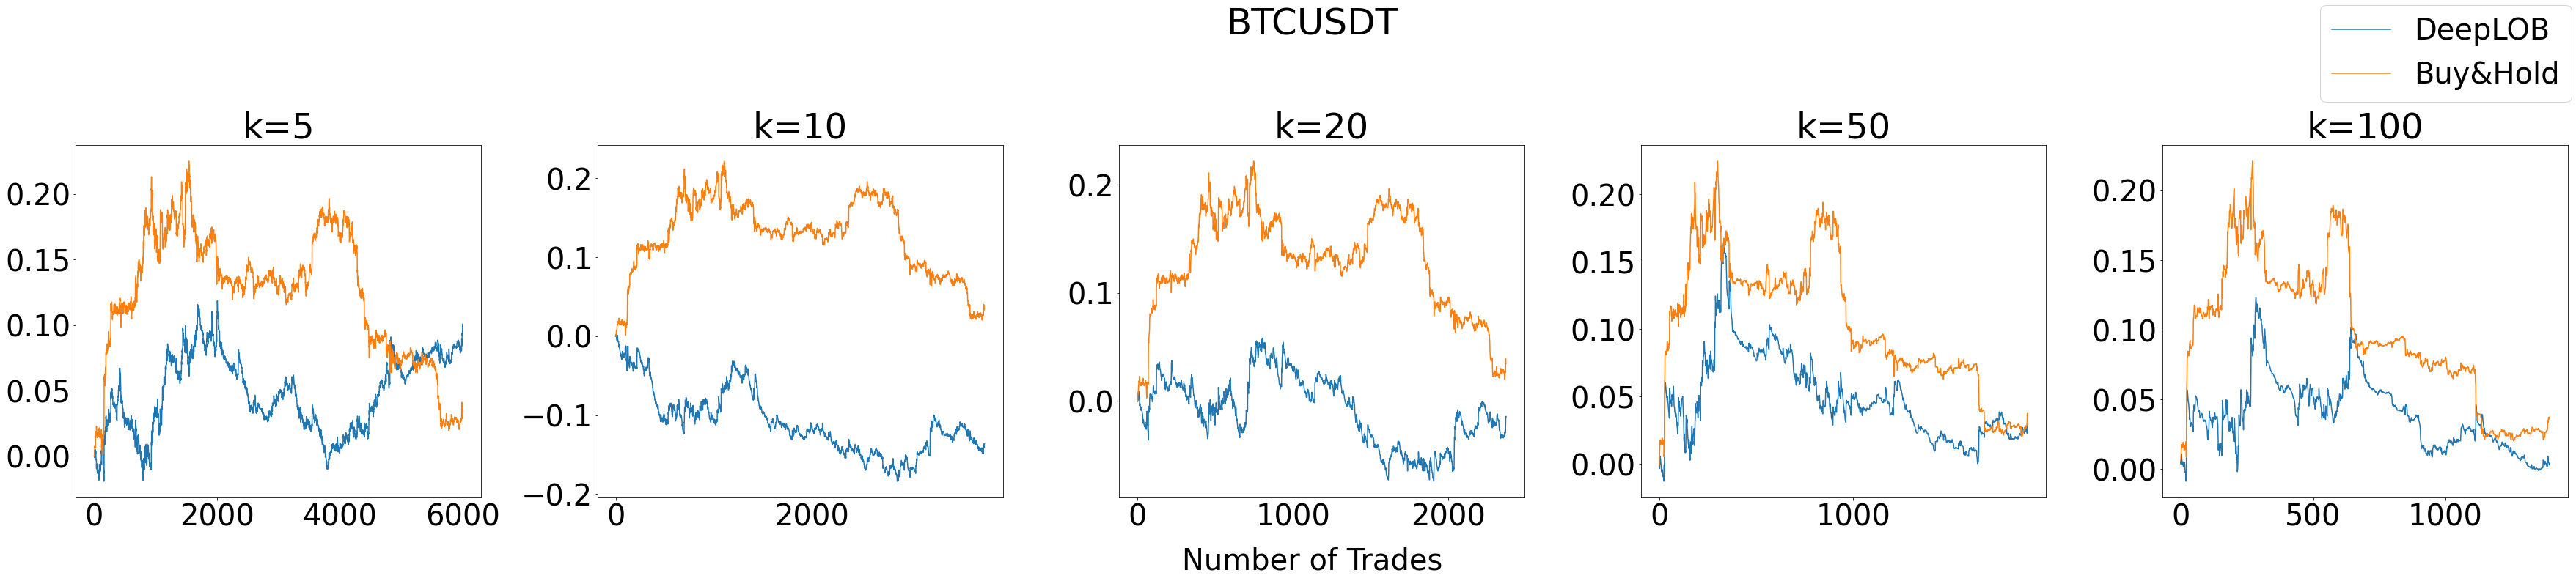

In [108]:
# Trading Strategy Analysis
pair = 'BTCUSDT'
test_pair = 'BTCUSDT'
#k = 10
T = 100
label_thresholds = {'BTCUSDT': [0.00035, 0.0005, 0.0007, 0.001, 0.0015],
                    'ETHUSDT': [0.00045, 0.00065, 0.0009, 0.0013, 0.0018],
                    'DOGEUSDT': [0.0005, 0.0007, 0.001, 0.0015, 0.002]}
label_alpha = label_thresholds[pair]
ks = [5, 10, 20, 50, 100]
label_lookback = ks
n_hiddens = 64
split = [0.7, 0.15]

entry_volume = 10_000

path = f'./Data/Norm_Data/{test_pair}.feather'
df = pd.read_feather(path)
df = create_labels(df, ks, label_alpha)
df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()
split = [0.7, 0.15]

train = data[:int(np.floor(data.shape[0] * split[0])), :]
val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]

for pred in ks:
    ind = ks.index(pred)
    alpha = label_alpha[ind]

    trainX_CNN, trainY_CNN = prepare_x_y(train, ind, T)
    valX_CNN, valY_CNN = prepare_x_y(val, ind, T)
    testX_CNN, testY_CNN = prepare_x_y(test, ind, T)


    model_path = f'./Checkpoints/Latest_4M_weights_{pair}_{pred}_{alpha}'
    model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
    model.load_weights(model_path)

    val_predictions = model.predict(valX_CNN)
    test_predictions = model.predict(testX_CNN)

    val_pred = np.argmax(val_predictions, axis=1)
    test_pred = np.argmax(test_predictions, axis=1)

    val_df = df.iloc[int(np.floor(data.shape[0] * split[0]))+99:int(np.floor(data.shape[0] * (split[0] + split[1]))), :]
    test_df = df.iloc[int(np.floor(data.shape[0] * (split[0] + split[1])))+99:, :]

    val_df['prediction'] = val_pred
    test_df['prediction'] = test_pred

    val_df['pred_prob'] = val_predictions.max(axis=1)
    test_df['pred_prob'] = test_predictions.max(axis=1)

    val_df['prediction'] = val_df['prediction'].replace(to_replace=1, method='ffill')
    test_df['prediction'] = test_df['prediction'].replace(to_replace=1, method='ffill')


    val_df['prediction_t-1'] = val_df['prediction'].shift(1)
    test_df['prediction_t-1'] = test_df['prediction'].shift(1)

    val_df['trade'] = np.where((val_df['prediction'] == 2) & (val_df['prediction_t-1'] != 2), -1, np.where((val_df['prediction'] == 0) & (val_df['prediction_t-1'] != 0), 1, 0))
    val_trades = val_df[val_df['prediction'] != val_df['prediction_t-1']]
    val_trades['exit_price_date'] = val_trades['date'].shift(-1)
    #val_trades = val_df[val_df['trade'] != 0]
    val_trades['entry_price'] = val_trades['mid_price']
    val_trades['exit_price'] = val_trades['mid_price'].shift(-1)
    val_trades['profit'] = (val_trades['exit_price'] - val_trades['entry_price']) * (val_trades['trade']) / val_trades['entry_price'] * 100
    val_trades['abs_profit'] = val_trades['profit'] / 100 * entry_volume
    val_trades['cum_abs_profit'] = val_trades['abs_profit'].cumsum()
    val_trades = val_trades[val_trades['trade'] != 0]

    #val_trades.groupby(pd.cut(val_trades["pred_prob"], np.arange(0, 1, 0.05))).mean()

    test_df['trade'] = np.where((test_df['prediction'] == 2) & (test_df['prediction_t-1'] != 2), -1, np.where((test_df['prediction'] == 0) & (test_df['prediction_t-1'] != 0), 1, 0))
    test_trades = test_df[test_df['prediction'] != test_df['prediction_t-1']]
    #test_trades = test_df[test_df['trade'] != 0]
    test_trades['exit_price_date'] = test_trades['date'].shift(-1)
    test_trades['entry_price'] = test_trades['mid_price']
    test_trades['exit_price'] = test_trades['mid_price'].shift(-1)
    test_trades['profit'] = (test_trades['exit_price'] - test_trades['entry_price']) * (test_trades['trade']) / test_trades['entry_price'] * 100
    test_trades['abs_profit'] = test_trades['profit'] / 100 * entry_volume
    test_trades['cum_abs_profit'] = test_trades['abs_profit'].cumsum()
    test_trades = test_trades[test_trades['trade'] != 0]
    
    globals()[f'ttrades_{pair}_{test_pair}_k_{pred}'] = test_trades.reset_index()
    globals()[f'vtrades_{pair}_{test_pair}_k_{pred}'] = val_trades.reset_index()

    
    score_plot(testY_CNN, test_predictions, 'test')

plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,11), sharex=False)
fig.suptitle(f'{pair}', fontsize=50)
#plt.suptitle(code+"\nK="+str(K))
fig.tight_layout(rect=[0, 0.02, 1, 0.93])
fig.text(0.5, 0.01, 'Number of Trades', ha='center')
for i, k in enumerate(ks):
    df = globals()[f'ttrades_{pair}_{test_pair}_k_{k}']
    df = df.reset_index()
    df['cum_abs_profit'] = df['cum_abs_profit'] / 10000
    df['hodl'] = df['mid_price'].shift(-1) / df['mid_price']
    df['cum_hodl'] = df['hodl'].cumprod() - 1
    ax[i].set_title(f'k={k}')
    ax[i].plot(df.index[:-1], df['cum_abs_profit'][:-1])
    ax[i].plot(df.index[:-1], df['cum_hodl'][:-1])
plt.legend(("DeepLOB", "Buy&Hold"),bbox_to_anchor=(1, 1, 0.045, 0.44))
plt.savefig(f'./Images/{pair}_on_{test_pair}.jpg')
plt.show()


# Trading strategy simulation - combined model

K: 5


2022-11-24 14:46:05.605545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 14:46:05.755538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trades['exit_price_date'] = val_trades['date'].shift(-1)
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

test
   Accuracy  Precision    Recall        F1
0   0.53874   0.532428  0.533928  0.532185
K: 10


2022-11-24 14:47:57.952910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 14:47:58.058296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trades['exit_price_date'] = val_trades['date'].shift(-1)
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

test
   Accuracy  Precision    Recall        F1
0  0.544161   0.546821  0.542499  0.543138
K: 20


2022-11-24 14:49:52.140549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 14:49:52.280307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trades['exit_price_date'] = val_trades['date'].shift(-1)
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_trades['profit'] = (test_trades['exit_price'] - test_trades['entry_price']) * (test_trades['trade']) / test_trades['entry_price'] * 100
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_trades['abs_profit'] = test_trades['profit'] / 100 * entry_volume
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w00

test
   Accuracy  Precision    Recall        F1
0  0.527743   0.532191  0.527805  0.526887
K: 50


2022-11-24 14:51:30.648699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 14:51:30.788264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trades['exit_price_date'] = val_trades['date'].shift(-1)
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

test
   Accuracy  Precision    Recall        F1
0  0.509015   0.524799  0.507568  0.507157


2022-11-24 14:53:09.966439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 14:53:10.091337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trades['exit_price_date'] = val_trades['date'].shift(-1)
/var/folders/c9/k_xs79fd1n38rxwgy0qzwf1w0000gn/T/ipykernel_2037/1556752431.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

K: 100
test
   Accuracy  Precision    Recall        F1
0  0.392613   0.395612  0.389329  0.386654


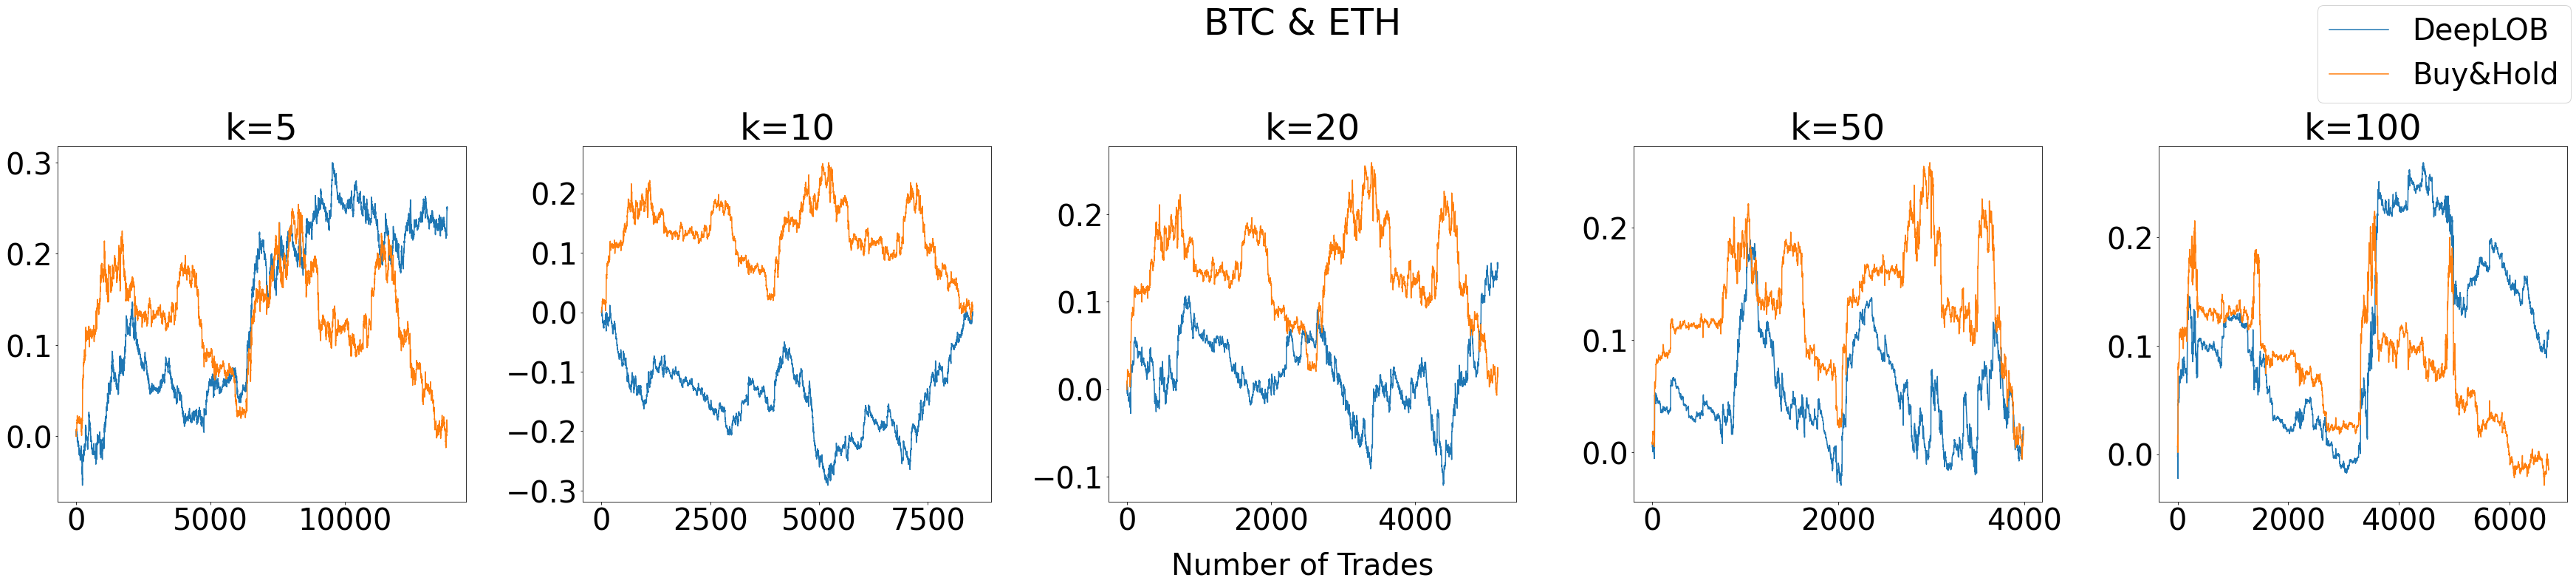

In [57]:
# Trading Strategy Analysis for combined set
model_pair = 'BTC&ETH'
test_pair = ['BTCUSDT', 'ETHUSDT']
#k = 10
T = 100
label_thresholds = {'BTCUSDT': [0.00035, 0.0005, 0.0007, 0.001, 0.0015],
                    'ETHUSDT': [0.00045, 0.00065, 0.0009, 0.0013, 0.0018],
                    'DOGEUSDT': [0.0005, 0.0007, 0.001, 0.0015, 0.002]}
if model_pair in label_thresholds:
    label_alpha = label_thresholds[pair]
else:
    label_alpha = [0.00035, 0.0005, 0.0007, 0.0011, 0.0015]

ks = [5, 10, 20, 50, 100]
label_lookback = ks
n_hiddens = 64
split = [0.7, 0.15]

entry_volume = 10_000

df_agg = pd.DataFrame()
df_val_agg = pd.DataFrame()
df_test_agg = pd.DataFrame()
data_agg = None

for pair in test_pair:
    path = f'./Data/Norm_Data/{pair}.feather'
    df = pd.read_feather(path)
    df = create_labels(df, ks, label_alpha)
    df = df[(df.date.dt.year > 2021) | ((df.date.dt.year == 2021) & (df.date.dt.month > 10))]
        
    data = df.loc[:,~df.columns.isin(['index', 'date', 'day', 'mid_price'])].to_numpy()
    
    train = data[:int(np.floor(data.shape[0] * split[0])), :]
    val = data[int(np.floor(data.shape[0] * split[0])):int(np.floor(data.shape[0] * (split[0] + split[1]))) , :]
    test = data[int(np.floor(data.shape[0] * (split[0] + split[1]))):, :]
    
    val_df = df.iloc[int(np.floor(data.shape[0] * split[0]))+99:int(np.floor(data.shape[0] * (split[0] + split[1]))), :]
    test_df = df.iloc[int(np.floor(data.shape[0] * (split[0] + split[1])))+99:, :]
    
    globals()[pair] = {'train': train, 'val': val, 'test': test}
    if df_agg.empty:
        df_agg = df.copy(deep=True)
        df_val_agg = val_df.copy(deep=True)
        df_test_agg = test_df.copy(deep=True)
        
    else:
        df_agg = pd.concat([df_agg, df],axis=0, ignore_index=True)
        df_val_agg = pd.concat([df_val_agg, val_df],axis=0, ignore_index=True)
        df_test_agg = pd.concat([df_test_agg, test_df],axis=0, ignore_index=True)        
        
    if data_agg is not None:
        data_agg = np.concatenate((data_agg, data))
    else:
        data_agg = data
        
for position, pred in enumerate(ks):
    trainX_CNN, trainY_CNN = None, None
    valX_CNN, valY_CNN = None, None
    testX_CNN, testY_CNN = None, None
    model_path = f'./Checkpoints/Latest_4M_weights_BTC&ETH_{pred}_{label_alpha[position]}'

    print(f'K: {pred}')
    for pair in test_pair:
        trainX, trainY = prepare_x_y(globals()[pair]["train"], position, T)
        valX, valY = prepare_x_y(globals()[pair]["val"], position, T)
        testX, testY = prepare_x_y(globals()[pair]["test"], position, T)
        
        trainX_CNN = np.concatenate((trainX_CNN, trainX)) if not trainX_CNN is None else trainX
        trainY_CNN = np.concatenate((trainY_CNN, trainY)) if not trainY_CNN is None else trainY
        valX_CNN = np.concatenate((valX_CNN, valX)) if not valX_CNN is None else valX
        valY_CNN = np.concatenate((valY_CNN, valY)) if not valY_CNN is None else valY
        testX_CNN = np.concatenate((testX_CNN, testX)) if not testX_CNN is None else testX
        testY_CNN = np.concatenate((testY_CNN, testY)) if not testY_CNN is None else testY
        
    model = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
    model.load_weights(model_path)

    val_predictions = model.predict(valX_CNN)
    test_predictions = model.predict(testX_CNN)

    val_pred = np.argmax(val_predictions, axis=1)
    test_pred = np.argmax(test_predictions, axis=1)

    val_df = df_val_agg.copy(deep=True)
    test_df = df_test_agg.copy(deep=True)

    val_df['prediction'] = val_pred
    test_df['prediction'] = test_pred

    val_df['pred_prob'] = val_predictions.max(axis=1)
    test_df['pred_prob'] = test_predictions.max(axis=1)

    val_df['prediction'] = val_df['prediction'].replace(to_replace=1, method='ffill')
    test_df['prediction'] = test_df['prediction'].replace(to_replace=1, method='ffill')


    val_df['prediction_t-1'] = val_df['prediction'].shift(1)
    test_df['prediction_t-1'] = test_df['prediction'].shift(1)

    val_df['trade'] = np.where((val_df['prediction'] == 2) & (val_df['prediction_t-1'] != 2), -1, np.where((val_df['prediction'] == 0) & (val_df['prediction_t-1'] != 0), 1, 0))
    val_trades = val_df[val_df['prediction'] != val_df['prediction_t-1']]
    val_trades['exit_price_date'] = val_trades['date'].shift(-1)
    #val_trades = val_df[val_df['trade'] != 0]
    val_trades['entry_price'] = val_trades['mid_price']
    val_trades['exit_price'] = val_trades['mid_price'].shift(-1)
    val_trades['profit'] = (val_trades['exit_price'] - val_trades['entry_price']) * (val_trades['trade']) / val_trades['entry_price'] * 100
    val_trades['abs_profit'] = val_trades['profit'] / 100 * entry_volume
    val_trades['cum_abs_profit'] = val_trades['abs_profit'].cumsum()
    val_trades = val_trades[val_trades['trade'] != 0]

    #val_trades.groupby(pd.cut(val_trades["pred_prob"], np.arange(0, 1, 0.05))).mean()

    test_df['trade'] = np.where((test_df['prediction'] == 2) & (test_df['prediction_t-1'] != 2), -1, np.where((test_df['prediction'] == 0) & (test_df['prediction_t-1'] != 0), 1, 0))
    test_trades = test_df[test_df['prediction'] != test_df['prediction_t-1']]
    test_trades['exit_price_date'] = test_trades['date'].shift(-1)
    #test_trades = test_df[test_df['trade'] != 0]
    test_trades['entry_price'] = test_trades['mid_price']
    test_trades['exit_price'] = test_trades['mid_price'].shift(-1)
    test_trades['profit'] = (test_trades['exit_price'] - test_trades['entry_price']) * (test_trades['trade']) / test_trades['entry_price'] * 100
    test_trades['abs_profit'] = test_trades['profit'] / 100 * entry_volume
    test_trades['abs_profit'] = np.where(test_trades['day'] > test_trades['day'].shift(-1), 0, test_trades['abs_profit'])
    test_trades['cum_abs_profit'] = test_trades['abs_profit'].cumsum()
    test_trades = test_trades[test_trades['trade'] != 0]

    globals()[f'ttrades_{model_pair}_{test_pair}_k_{pred}'] = test_trades.reset_index()
    globals()[f'vtrades_{model_pair}_{test_pair}_k_{pred}'] = val_trades.reset_index()


    score_plot(testY_CNN, test_predictions, 'test')


plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,11), sharex=False)
fig.suptitle('BTC & ETH', fontsize=50)
#plt.suptitle(code+"\nK="+str(K))
fig.tight_layout(rect=[0, 0.02, 1, 0.93])
fig.text(0.5, 0.01, 'Number of Trades', ha='center')
for i, k in enumerate(ks):
    df = globals()[f'ttrades_{model_pair}_{test_pair}_k_{k}']
    df = df.reset_index()
    df['cum_abs_profit'] = df['cum_abs_profit'] / 10000
    #df['cum_abs_profit'] = np.where(df['day'] > df['day'].shift(-1), 0, df['cum_abs_profit'])
    df['hodl'] = df['mid_price'].shift(-1) / df['mid_price']
    df['hodl'] = np.where(df['day'] > df['day'].shift(-1), 1, df['hodl'])
    df['cum_hodl'] = df['hodl'].cumprod() - 1
    ax[i].set_title(f'k={k}')
    ax[i].plot(df.index[:-1], df['cum_abs_profit'][:-1])
    ax[i].plot(df.index[:-1], df['cum_hodl'][:-1])
plt.legend(("DeepLOB", "Buy&Hold"),bbox_to_anchor=(1, 1, 0.045, 0.44))
plt.savefig(f'./Images/{model_pair}_on_{model_pair}.jpg')
plt.show()

# Creation of Trading Strategy Results Table

In [112]:
pairs = ['BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'BTC&ETH']
ks = [5, 10, 20, 50, 100]

for pair in pairs:
    output = pd.DataFrame()
    for k in ks:
        if pair == 'BTC&ETH':
            df = globals()[f'ttrades_{pair}_{["BTCUSDT", "ETHUSDT"]}_k_{k}']
        else:
            df = globals()[f'ttrades_{pair}_{pair}_k_{k}']
        tot_ret = df.iloc[-2,:]['cum_abs_profit'] / 10_000
        avg_ret = df['profit'].mean()
        vol = df['profit'].std()
        med = df['profit'].median()
        
        add = pd.DataFrame([[tot_ret, avg_ret, vol, med]], columns = ['Total Return', 'Avg Return', 'Volatility', 'Median'],
                          index = [f'{k}'])
        output = pd.concat([output, add])
        
    print(pair)
    print(output) 
        

BTCUSDT
     Total Return  Avg Return  Volatility    Median
5        0.100312    0.001171    0.141816 -0.014660
10      -0.132149   -0.002148    0.166314 -0.015976
20      -0.013575   -0.000280    0.190744 -0.007291
50       0.028518    0.000751    0.217615 -0.004784
100      0.002571    0.000062    0.194986 -0.004772
DOGEUSDT
     Total Return  Avg Return  Volatility  Median
5        0.545147    0.007377    0.202137    -0.0
10       0.472724    0.009415    0.245930     0.0
20       0.490747    0.013579    0.288883     0.0
50       0.077543    0.002532    0.315781     0.0
100     -0.003108   -0.000137    0.366691    -0.0
ETHUSDT
     Total Return  Avg Return  Volatility    Median
5        0.173382    0.001950    0.169172 -0.021283
10       0.107414    0.001764    0.209616 -0.024417
20       0.099841    0.001896    0.226548 -0.018972
50       0.160453    0.004357    0.275306 -0.006519
100      0.437170    0.009999    0.252207  0.000000
BTC&ETH
     Total Return  Avg Return  Volatility  

# Trading Strategy Analysis - Including Spreads

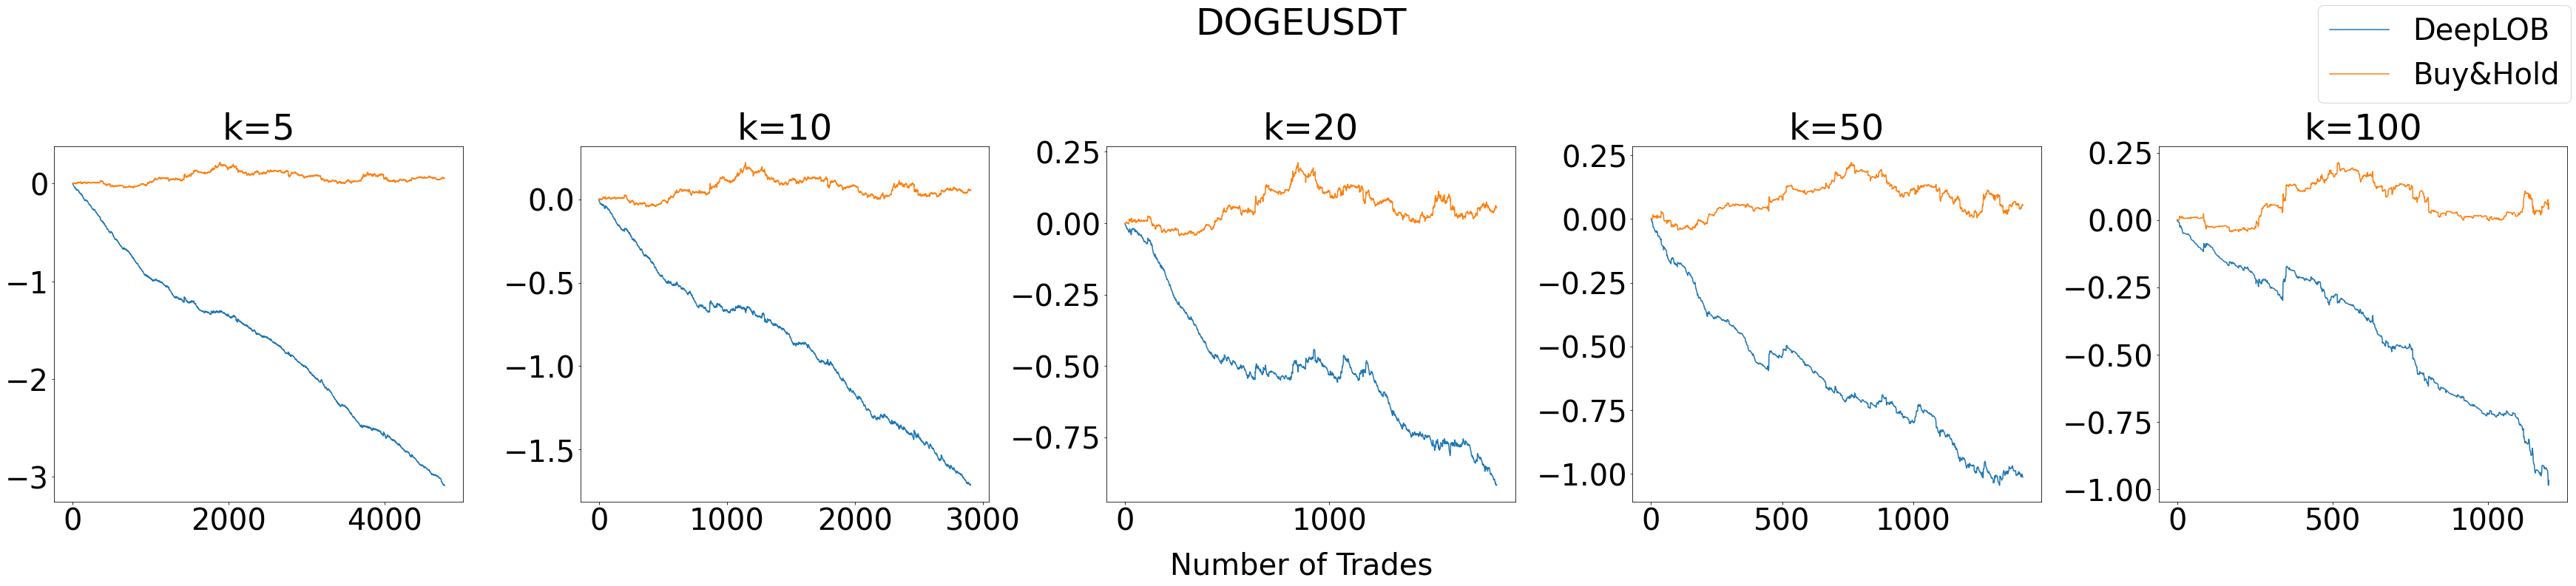

In [111]:
pair = 'DOGEUSDT'
ks = [5, 10, 20, 50, 100]
if pair == 'BTC&ETH':
    book1 = pd.read_parquet(f'./Data/Clean_Data/Binance-BTCUSDT_full.par')
    book2 = pd.read_parquet(f'./Data/Clean_Data/Binance-ETHUSDT_full.par')
    for k in ks:
        print(k)
        df = globals()[f"ttrades_BTC&ETH_['BTCUSDT', 'ETHUSDT']_k_{k}"]
        ETH_temp = df.iloc[df[df['day']< df['day'].shift(1)].index[0]:,]
        BTC_temp = df.iloc[:df[df['day']< df['day'].shift(1)].index[0],]
        trade_dates_BTC = pd.DataFrame()
        trade_dates_ETH = pd.DataFrame()
        trade_dates_BTC['date'] = pd.unique(BTC_temp[['date', 'exit_price_date']].values.ravel('K'))
        trade_dates_ETH['date'] = pd.unique(ETH_temp[['date', 'exit_price_date']].values.ravel('K'))
        trade_dates_BTC = pd.merge(trade_dates_BTC, book1, how = 'left')
        trade_dates_ETH = pd.merge(trade_dates_ETH, book2, how = 'left')
        trade_dates_BTC['ask_USDT_volume'] = trade_dates_BTC['ask_price'] * trade_dates_BTC['ask_amount']
        trade_dates_BTC['bid_USDT_volume'] = trade_dates_BTC['bid_price'] * trade_dates_BTC['bid_amount']
        trade_dates_ETH['ask_USDT_volume'] = trade_dates_ETH['ask_price'] * trade_dates_ETH['ask_amount']
        trade_dates_ETH['bid_USDT_volume'] = trade_dates_ETH['bid_price'] * trade_dates_ETH['bid_amount']
        effective_prices_BTC = trade_dates_BTC.groupby(['date']).apply(lambda x: spread(x, 10_000)).reset_index(drop=True)
        effective_prices_ETH = trade_dates_ETH.groupby(['date']).apply(lambda x: spread(x, 10_000)).reset_index(drop=True)
        trades_spread_BTC = pd.merge(BTC_temp, effective_prices_BTC, how='left', left_on = 'date', right_on='date')
        trades_spread_BTC = pd.merge(trades_spread_BTC, effective_prices_BTC, how='left', left_on = 'exit_price_date', right_on = 'date', suffixes = ('_entry', '_exit'))
        
        trades_spread_ETH = pd.merge(ETH_temp, effective_prices_ETH, how='left', left_on = 'date', right_on='date')
        trades_spread_ETH = pd.merge(trades_spread_ETH, effective_prices_ETH, how='left', left_on = 'exit_price_date', right_on = 'date', suffixes = ('_entry', '_exit'))
        
        trades_spread = pd.concat([trades_spread_BTC, trades_spread_ETH])
        trades_spread['entry_price'] = np.where(trades_spread['trade'] == 1, trades_spread['ask_average_price_entry'], trades_spread['bid_average_price_entry'])
        trades_spread['exit_price'] = np.where(trades_spread['trade'] == 1, trades_spread['bid_average_price_exit'], trades_spread['ask_average_price_exit'])
        trades_spread['profit'] = (trades_spread['exit_price'] - trades_spread['entry_price']) * (trades_spread['trade']) / trades_spread['entry_price'] * 100
        trades_spread['abs_profit'] = trades_spread['profit'] / 100 * entry_volume
        trades_spread['cum_abs_profit'] = trades_spread['abs_profit'].cumsum()
        
        globals()[f'ttrades_spread_BTC&ETH_BTC&ETH_k_{k}'] = trades_spread
        
else:
    book = pd.read_parquet(f'./Data/Clean_Data/Binance-{pair}_full.par')    
    for k in ks:
        df = globals()[f'ttrades_{pair}_{pair}_k_{k}']
        trade_dates = pd.DataFrame()
        trade_dates['date'] = pd.unique(df[['date', 'exit_price_date']].values.ravel('K'))
        trade_dates = pd.merge(trade_dates, book, how = 'left')
        trade_dates['ask_USDT_volume'] = trade_dates['ask_price'] * trade_dates['ask_amount']
        trade_dates['bid_USDT_volume'] = trade_dates['bid_price'] * trade_dates['bid_amount']
        effective_prices = trade_dates.groupby(['date']).apply(lambda x: spread(x, 10_000)).reset_index(drop=True)
        trades_spread = pd.merge(df, effective_prices, how='left', left_on = 'date', right_on='date')
        trades_spread = pd.merge(trades_spread, effective_prices, how='left', left_on = 'exit_price_date', right_on = 'date', suffixes = ('_entry', '_exit'))

        trades_spread['entry_price'] = np.where(trades_spread['trade'] == 1, trades_spread['ask_average_price_entry'], trades_spread['bid_average_price_entry'])
        trades_spread['exit_price'] = np.where(trades_spread['trade'] == 1, trades_spread['bid_average_price_exit'], trades_spread['ask_average_price_exit'])

        trades_spread['profit'] = (trades_spread['exit_price'] - trades_spread['entry_price']) * (trades_spread['trade']) / trades_spread['entry_price'] * 100
        trades_spread['abs_profit'] = trades_spread['profit'] / 100 * entry_volume
        trades_spread['abs_profit'] = np.where(trades_spread['day'] > trades_spread['day'].shift(-1), 0, trades_spread['abs_profit'])
        trades_spread['cum_abs_profit'] = trades_spread['abs_profit'].cumsum()

        globals()[f'ttrades_spread_{pair}_{pair}_k_{k}'] = trades_spread
    
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,11), sharex=False)
fig.suptitle(f'{pair}', fontsize=50)
#plt.suptitle(code+"\nK="+str(K))
fig.tight_layout(rect=[0, 0.02, 1, 0.93], h_pad = 10)
fig.text(0.5, 0.01, 'Number of Trades', ha='center')
for i, k in enumerate(ks):
    df = globals()[f'ttrades_spread_{pair}_{pair}_k_{k}']
    df = df.reset_index()
    df['cum_abs_profit'] = df['cum_abs_profit'] / 10000
    df['hodl'] = df['mid_price'].shift(-1) / df['mid_price']
    df['hodl'] = np.where(df['day'] > df['day'].shift(-1), 1, df['hodl'])
    df['cum_hodl'] = df['hodl'].cumprod() - 1
    ax[i].set_title(f'k={k}')
    ax[i].plot(df.index[:-1], df['cum_abs_profit'][:-1])
    ax[i].plot(df.index[:-1], df['cum_hodl'][:-1])
plt.legend(("DeepLOB", "Buy&Hold"),bbox_to_anchor=(1, 1, 0.045, 0.44))
plt.savefig(f'./Images/Spread_{pair}_on_{test_pair}.jpg')
plt.show()
    

# Average Trading Profit breakdown per Softmax Bracket

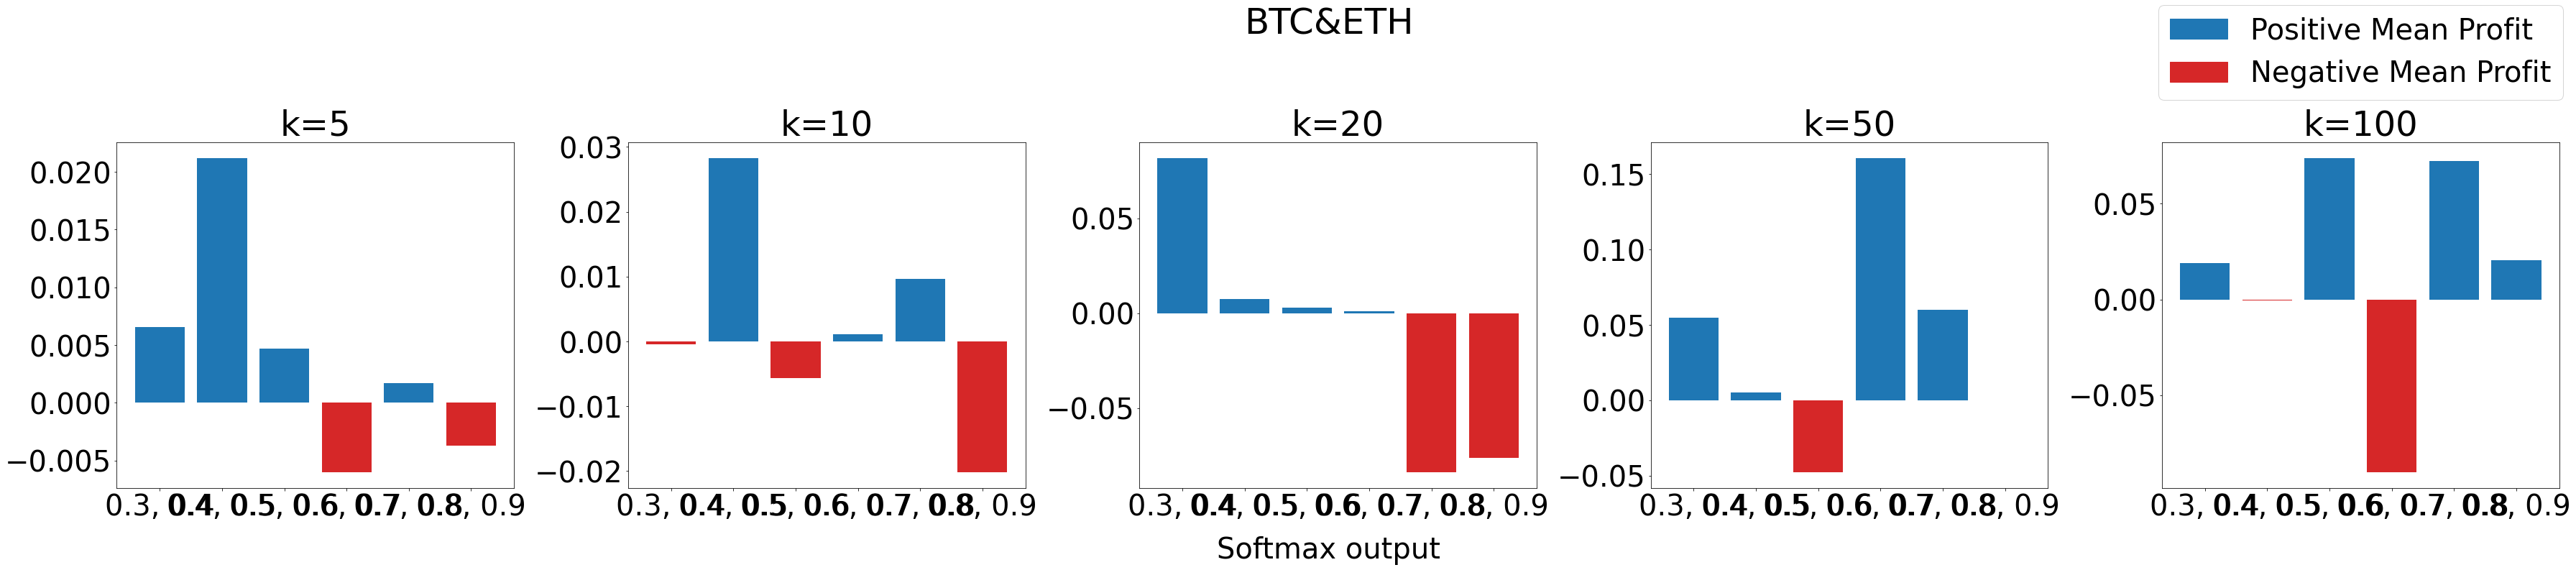

In [119]:
pair = 'DOGEUSDT'
ks = [5, 10, 20, 50, 100]
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,11), sharex=False)
fig.suptitle(f'{model_pair}', fontsize=50)
#plt.suptitle(code+"\nK="+str(K))
fig.tight_layout(rect=[0, 0.02, 1, 0.93], h_pad = 10)
fig.text(0.5, 0.01, 'Softmax output', ha='center')
for i, k in enumerate(ks):
    df = globals()[f'ttrades_{model_pair}_{test_pair}_k_{k}']
    #df = globals()[f'ttrades_{pair}_{pair}_k_{k}']
    a = df.groupby(pd.cut(df["pred_prob"], np.arange(0.3, 1, 0.1)))[['profit', 'abs_profit']].mean()
    b = df.groupby(pd.cut(df["pred_prob"], np.arange(0.3, 1, 0.1)))[['profit', 'abs_profit']].median()
    output = pd.merge(a,b, left_index=True, right_index=True, suffixes = ('_mean', '_median'))
    output = output.fillna(0)
    output['categories'] = output.index.astype(str)
    output['categories'] = output['categories'].str.replace("(", "", regex=True)
    output['categories'] = output['categories'].str.replace("]", "",regex=True)
    
    ax[i].set_title(f'k={k}')
    color = ['tab:red' if y<0 else 'tab:blue' for y in output['profit_mean']]
    ax[i].bar(output['categories'], output['profit_mean'], color = color)
    #ax[i].bar(output['categories'],output['profit_median'])
    #ax.set_xticklabels([c[1:-1].replace(","," to") for c in output.cat.categories])

blue_patch = mpatches.Patch(color='tab:blue', label='Positive Mean Profit')
red_patch = mpatches.Patch(color='tab:red', label='Negative Mean Profit')
plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1, 1, 0.045, 0.44)) 
#plt.legend(("Mean Profit", "Median"),bbox_to_anchor=(1, 1, 0.045, 0.44))
#plt.savefig(f'./Images/Bar_chart{pair}_on_{pair}.jpg')
plt.savefig(f'./Images/Bar_chart{model_pair}_on_{model_pair}.jpg')
plt.show()


# Average Trading profit per Trade per Long/Short

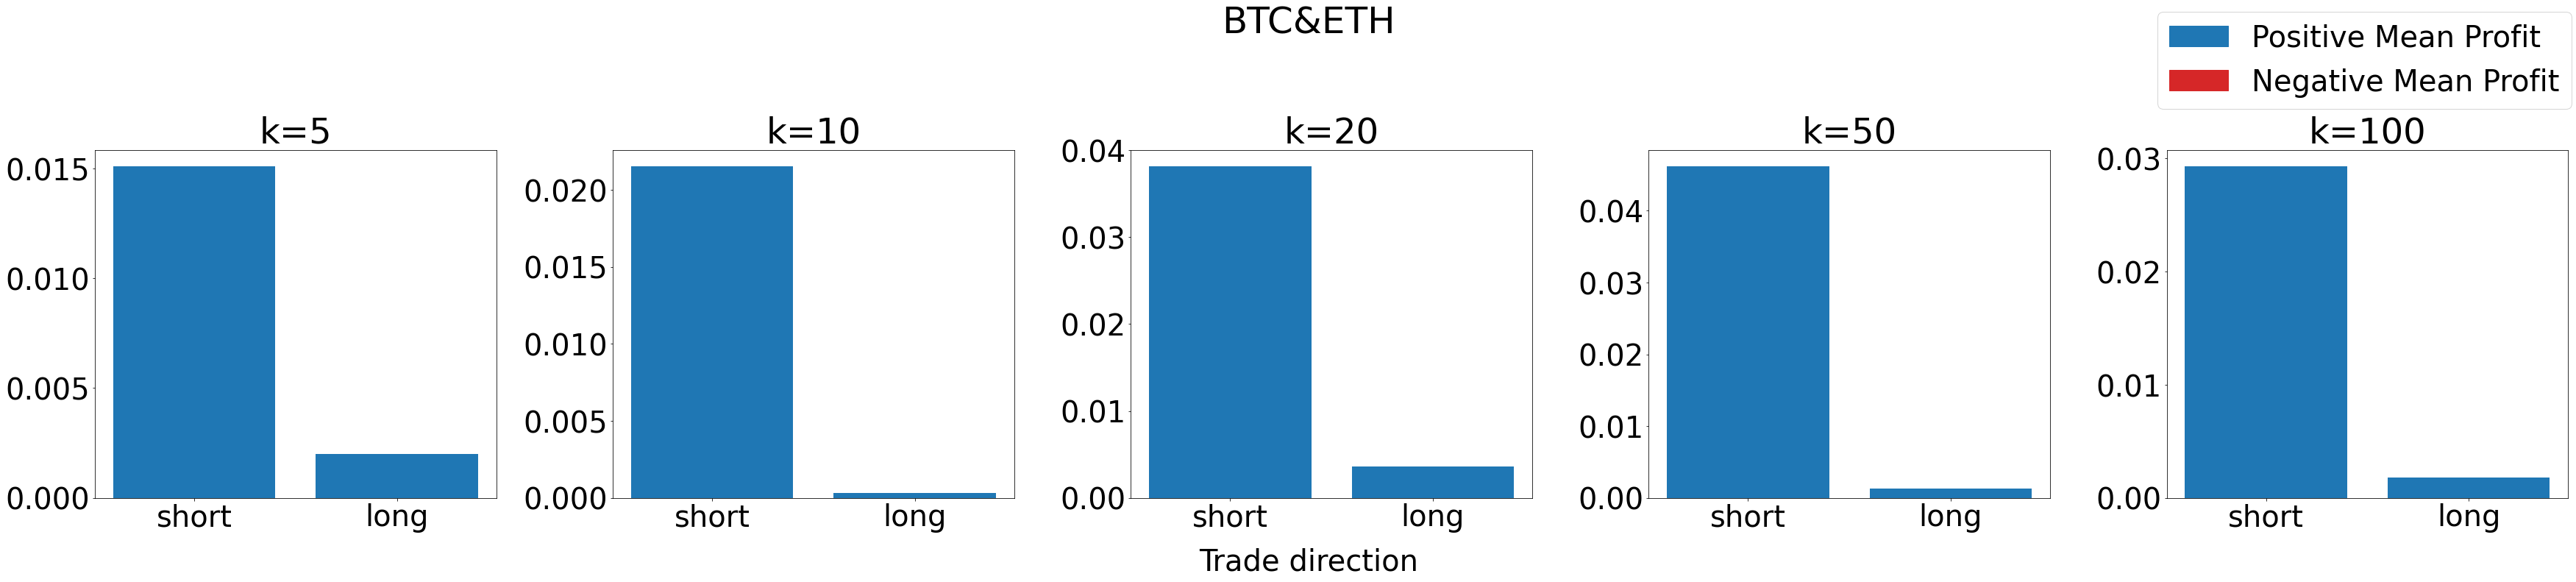

In [118]:
pair = 'BTCUSDT'
ks = [5, 10, 20, 50, 100]
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,11), sharex=False)
fig.suptitle(f'{model_pair}', fontsize=50)
#plt.suptitle(code+"\nK="+str(K))
fig.tight_layout(rect=[0.01, 0.02, 1, 0.92], h_pad = 10)
fig.text(0.5, 0.01, 'Trade direction', ha='center')
for i, k in enumerate(ks):
    df = globals()[f'ttrades_{model_pair}_{test_pair}_k_{k}']
    #df = globals()[f'ttrades_{pair}_{pair}_k_{k}']
    output = df.groupby(df['trade'])[['profit', 'abs_profit']].mean()
    output['trade'] = np.where(output.index == 1, 'long', 'short')
    ax[i].set_title(f'k={k}')
    color = ['tab:red' if y<0 else 'tab:blue' for y in output['profit']]
    ax[i].bar(output['trade'], output['profit'], color = color)
    #ax[i].bar(output['categories'],output['profit_median'])
    #ax.set_xticklabels([c[1:-1].replace(","," to") for c in output.cat.categories])

blue_patch = mpatches.Patch(color='tab:blue', label='Positive Mean Profit')
red_patch = mpatches.Patch(color='tab:red', label='Negative Mean Profit')
plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1, 1, 0.045, 0.44))    
#plt.legend(("Mean Profit", "Mean Profit (positive)"),bbox_to_anchor=(1, 1, 0.045, 0.44))
#plt.savefig(f'./Images/Bar_Long-Short_{pair}_on_{pair}.jpg')
plt.savefig(f'./Images/Bar_Long-Short_{model_pair}_on_{model_pair}.jpg')
plt.show()

# Price development plot

## Load data

In [3]:
# create price plot of currencies
pairs = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT', 'XRPUSDT', 'LTCUSDT', 'LINKUSDT', 'ETHBTC', 'LINKETH']

df = pd.DataFrame()

for pair in pairs:
    path = f'./Data/Daily_Prices/Binance_{pair}_d.csv'
    d = pd.read_csv(path, skiprows = 1)
    d['date'] = d['date'].astype('datetime64[s]')
    d = d.loc[d['date'].between("2021-11-01", "2022-02-20")]
    if df.empty:
        df = d[['date', 'close']]
        df = df.rename(columns={"close": pair})
    else:
        df[pair] = d['close'].values
df = df.sort_values(by='date')
df = df.reset_index(drop=True)
returns = df.copy(deep=True)
price_development = df.copy(deep=True)
for pair in pairs:
    returns[pair] = (df[pair] - df[pair].shift(1)) / df[pair].shift(1)
    r = returns[pair] + 1
    price_development[pair] = r.cumprod() * 100
    price_development.loc[0, pair] = 100
    


## Formatting of plot

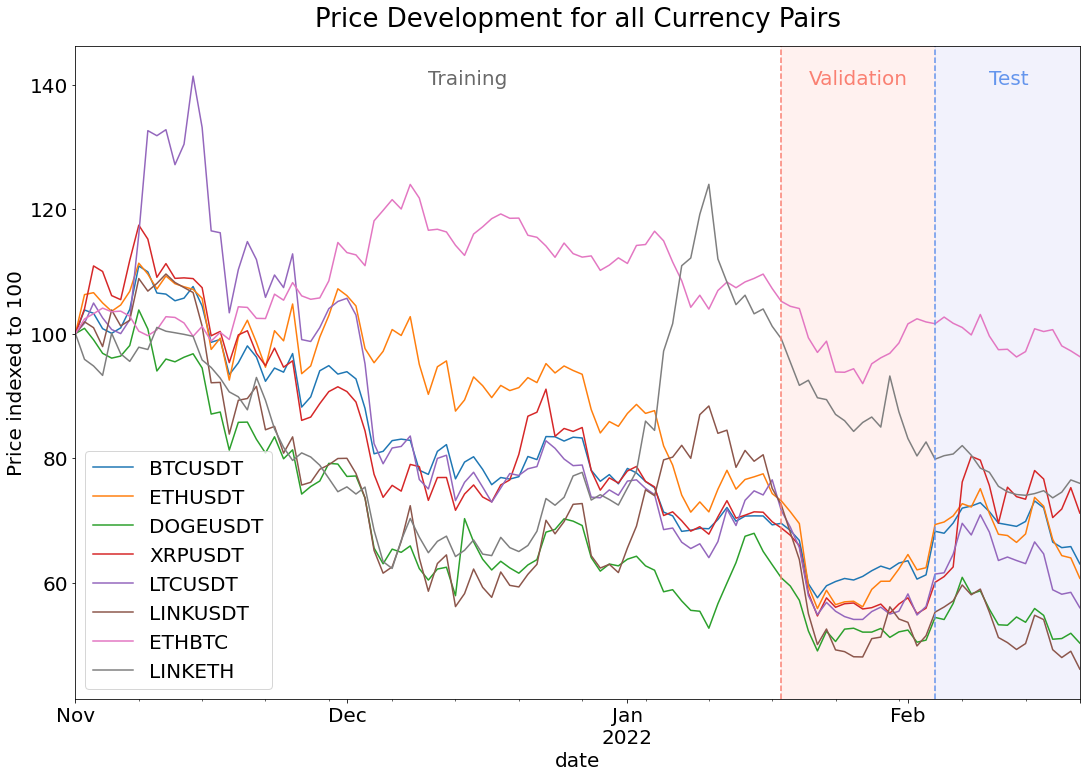

In [10]:
plt.rcParams.update({'font.size': 20})
p = price_development.plot(x = 'date',figsize=(18,12))
p.set_title('Price Development for all Currency Pairs',pad=20, fontdict={'fontsize':26})
p.axvline("2022-01-18", color="salmon", linestyle="--")
p.axvline("2022-02-04", color="cornflowerblue", linestyle="--")
p.axvspan("2022-01-18", "2022-02-04", alpha=0.5, color='mistyrose')
p.axvspan("2022-02-04", "2022-02-20", alpha=0.5, color='lavender')
p.text("2022-01-21", 140, 'Validation', fontsize=20, color = 'salmon')
p.text("2022-02-10", 140, 'Test', fontsize=20, color = 'cornflowerblue')
p.text("2021-12-10", 140, 'Training', fontsize=20, color = 'dimgray')
plt.ylabel("Price indexed to 100")
p.get_figure().savefig("./Images/Price_Development.jpg",bbox_inches='tight')

# Correlation matrix of daily returns

In [4]:
# Correlations between daily returns
corr = returns.corr()
#corr.style.background_gradient(cmap='coolwarm').format(precision=2)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,BTCUSDT,ETHUSDT,DOGEUSDT,XRPUSDT,LTCUSDT,LINKUSDT,ETHBTC,LINKETH
BTCUSDT,nan,nan,nan,nan,nan,nan,nan,nan
ETHUSDT,0.87,nan,nan,nan,nan,nan,nan,nan
DOGEUSDT,0.75,0.69,nan,nan,nan,nan,nan,nan
XRPUSDT,0.75,0.73,0.68,nan,nan,nan,nan,nan
LTCUSDT,0.83,0.77,0.71,0.71,nan,nan,nan,nan
LINKUSDT,0.70,0.70,0.56,0.60,0.65,nan,nan,nan
ETHBTC,0.17,0.63,0.21,0.29,0.24,0.30,nan,nan
LINKETH,0.05,-0.08,0.05,0.06,0.09,0.66,-0.24,nan
